### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from os import walk

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from scipy import stats

#### Load all sheets in the underlying file

In [2]:
file_path = '../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

file_list = []
for (dirpath, dirnames, filenames) in walk(file_path):
    file_list.extend(filenames)
    break

file_list = [x for x in file_list if x[-3:] == 'csv']

In [3]:
##sheet = client.open('Learning Log').sheet1

raw_df = pd.DataFrame()
for file_name in file_list:
    sub_table = pd.read_csv(file_path + file_name)
    sub_table['sheet_name'] = file_name.split('.')[0]
    raw_df = pd.concat([raw_df, sub_table])

raw_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name
0,Hubei,Mainland China,2020-02-26T14:13:10,65187.0,2615.0,20969.0,02-26-2020
1,Guangdong,Mainland China,2020-02-26T10:33:02,1347.0,7.0,851.0,02-26-2020
2,Henan,Mainland China,2020-02-26T10:33:02,1271.0,19.0,1033.0,02-26-2020
3,NaN,South Korea,2020-02-26T11:03:11,1261.0,12.0,22.0,02-26-2020
4,Zhejiang,Mainland China,2020-02-26T10:33:02,1205.0,1.0,867.0,02-26-2020


In [4]:
raw_df.describe(include=[np.object])

,Province/State,Country/Region,Last Update,sheet_name
count,1838,2585,2585,2585
unique,72,56,742,37
top,Xinjiang,Mainland China,2020-02-01T19:43:03,02-27-2020
freq,37,1141,63,105


In [5]:
# Merge duplicate columns with different names

main_df = raw_df

# main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

# main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

# main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update', '',
                                                'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'
                                                'Announcement'])]

## main_df = main_df.drop(columns=['Announcement',
                      ## 'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])

main_df.sample(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name
34,Thailand,Thailand,2020-02-17T07:33:02,35.0,0.0,15.0,02-20-2020
60,Finland,Finland,2020-01-31T08:15:53,1.0,0.0,0.0,02-08-2020
3,Henan,Mainland China,2/1/2020 1:52,422.0,2.0,3.0,02-01-2020
65,"Boston, MA",US,2020-02-01T19:43:03,1.0,0.0,0.0,02-04-2020
76,Sri Lanka,Sri Lanka,2020-02-08T03:43:03,1.0,0.0,1.0,02-24-2020


In [6]:
main_df.sheet_name.str.split('-')

0     [02, 26, 2020]
1     [02, 26, 2020]
2     [02, 26, 2020]
3     [02, 26, 2020]
4     [02, 26, 2020]
           ...      
62    [02, 01, 2020]
63    [02, 01, 2020]
64    [02, 01, 2020]
65    [02, 01, 2020]
66    [02, 01, 2020]
Name: sheet_name, Length: 2585, dtype: object

In [7]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('-').apply(lambda x: x[0])
main_df['day'] = main_df.sheet_name.str.split('-').apply(lambda x: x[1])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
# main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau','Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

In [8]:
main_df

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name,month,day
0,Hubei,Mainland China,2020-02-26 12:13:10,65187.0,2615.0,20969.0,02-26-2020,02,26
1,Guangdong,Mainland China,2020-02-26 08:33:02,1347.0,7.0,851.0,02-26-2020,02,26
2,Henan,Mainland China,2020-02-26 08:33:02,1271.0,19.0,1033.0,02-26-2020,02,26
3,South Korea,South Korea,2020-02-26 09:03:11,1261.0,12.0,22.0,02-26-2020,02,26
4,Zhejiang,Mainland China,2020-02-26 08:33:02,1205.0,1.0,867.0,02-26-2020,02,26
...,...,...,...,...,...,...,...,...,...
62,"Los Angeles, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
63,"Orange, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
64,"Santa Clara, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
65,"Seattle, WA",US,2020-02-01 17:43:00,1.0,0.0,0.0,02-01-2020,02,01


In [9]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  ## 'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period
0,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24
1,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25
2,Afghanistan,Afghanistan,02,26,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-26
3,Afghanistan,Afghanistan,02,27,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-27
4,Algeria,Algeria,02,25,2020-02-25 21:43:03,1.0,0.0,0.0,2020-02-25
...,...,...,...,...,...,...,...,...,...
2580,Vietnam,Vietnam,02,23,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-23
2581,Vietnam,Vietnam,02,24,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-24
2582,Vietnam,Vietnam,02,25,2020-02-25 06:53:02,16.0,16.0,0.0,2020-02-25
2583,Vietnam,Vietnam,02,26,2020-02-25 06:53:02,16.0,16.0,0.0,2020-02-26


#### Some baisc checks

2020-01-22 15:00:00    38
2020-01-23 15:00:00    46
2020-01-24 15:00:00    41
2020-01-25 15:00:00    44
2020-01-26 14:00:00    47
                       ..
2020-02-27 20:43:02     1
2020-02-27 21:03:11     1
2020-02-27 21:13:04     3
2020-02-27 21:23:02     2
2020-02-27 21:33:02     2
Name: Last Update, Length: 741, dtype: int64

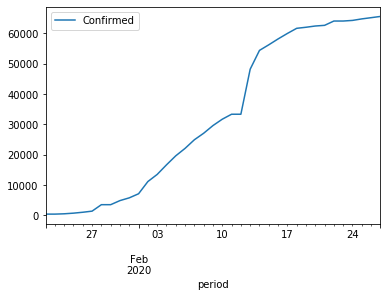

In [10]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [11]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Denmark            1
Estonia            1
Travis, CA         1
Colombia           1
Ashland, NE        1
Netherlands        1
San Marino         1
Ivory Coast        1
Chicago            1
Lackland, TX       1
Mexico             1
Romania            2
Israel             2
North Macedonia    2
Cruise Ship        2
Greece             2
Austria            2
Pakistan           2
Norway             2
Georgia            2
Name: Province/State, dtype: int64

In [12]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Denmark', 'Estonia', 'Travis, CA', 'Colombia', 'Ashland, NE',
       'Netherlands', 'San Marino', 'Ivory Coast', 'Chicago', 'Lackland, TX'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

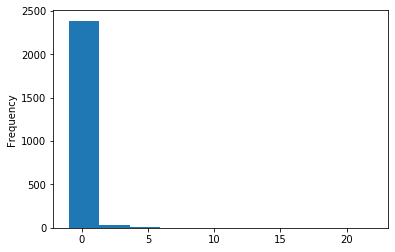

In [13]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [14]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
50,Australia,Queensland,01,31,2020-01-31 21:59:00,2.0,0.0,0.0,2020-01-31,3.0,-1.0,-0.333333
52,Australia,Queensland,02,02,2020-02-02 20:33:07,2.0,0.0,0.0,2020-02-02,3.0,-1.0,-0.333333
490,Iraq,None,02,23,2020-02-23 16:23:06,0.0,0.0,0.0,2020-02-23,2.0,-2.0,-1.000000
491,Israel,From Diamond Princess,02,21,2020-02-21 13:33:03,1.0,0.0,0.0,2020-02-21,8.0,-7.0,-0.875000
528,Japan,Japan,01,23,2020-01-23 15:00:00,1.0,0.0,0.0,2020-01-23,2.0,-1.0,-0.500000
543,Japan,Japan,02,07,2020-02-07 02:13:20,25.0,1.0,0.0,2020-02-07,45.0,-20.0,-0.444444
2266,US,"Lackland, TX (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,2.0,-2.0,-1.000000
2322,US,"Omaha, NE (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,11.0,-11.0,-1.000000
2501,US,"Travis, CA (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,5.0,-5.0,-1.000000


In [15]:
# focus on cases where base is above 20
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 20]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,1405.968807,278.560550,38.430275,1331.700000,74.268807,0.102665,15.386239
std,7492.973281,1581.939586,257.033378,7237.669113,568.610920,0.194994,9.272252
min,20.000000,0.000000,0.000000,20.000000,-20.000000,-0.444444,1.000000
25%,75.000000,5.000000,0.000000,69.250000,1.000000,0.001373,7.000000
50%,168.000000,28.500000,1.000000,151.500000,5.000000,0.033254,15.000000
75%,480.000000,112.000000,2.000000,453.750000,19.000000,0.116470,23.000000
max,65596.000000,23383.000000,2641.000000,65187.000000,14840.000000,2.354839,36.000000


In [16]:
growth_df = heavy_affect_df.\
    pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').\
    reset_index()
growth_df

Province/State,day count,Anhui,Bahrain,Beijing,Chongqing,Cruise Ship,Diamond Princess cruise ship,Fujian,Gansu,Germany,...,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Unassigned Location (From Diamond Princess),Xinjiang,Yunnan,Zhejiang
0,1.0,0.538462,0.434783,0.636364,1.111111,0.0,1.109375,0.685714,0.083333,0.703704,...,0.571429,0.166667,0.043478,0.100000,0.000000,0.043478,0.000000,0.142857,0.692308,0.592593
1,2.0,0.166667,0.000000,0.138889,0.315789,NaN,0.000000,0.355932,0.115385,NaN,...,0.568182,0.000000,0.000000,0.000000,0.000000,0.125000,0.166667,0.208333,0.250000,0.441860
2,3.0,0.514286,NaN,0.658537,0.466667,NaN,0.296296,0.050000,0.379310,NaN,...,0.304348,0.071429,0.041667,0.045455,0.000000,0.148148,0.000000,0.103448,0.272727,0.677419
3,4.0,0.433962,NaN,0.176471,0.200000,NaN,0.000000,0.202381,0.275000,NaN,...,0.200000,0.100000,0.080000,0.043478,0.280000,0.032258,NaN,0.125000,0.185714,0.230769
4,5.0,0.315789,NaN,0.137500,0.113636,NaN,0.245714,0.188119,0.078431,NaN,...,0.314815,0.212121,0.037037,0.083333,0.000000,0.281250,NaN,0.083333,0.120482,0.351562
5,6.0,0.185000,NaN,0.219780,0.238095,NaN,0.307339,0.200000,0.036364,NaN,...,0.246479,0.125000,0.000000,0.000000,0.000000,0.170732,NaN,0.076923,0.129032,0.710983
6,7.0,0.253165,NaN,0.027027,0.159341,NaN,0.245614,0.104167,0.087719,NaN,...,0.169492,0.044444,0.000000,0.076923,0.031250,0.250000,NaN,0.071429,0.114286,0.445946
7,8.0,0.144781,NaN,0.219298,0.170616,NaN,0.278873,0.125786,0.000000,NaN,...,0.115942,0.063830,0.000000,0.071429,0.000000,0.116667,NaN,0.088889,0.042735,0.257009
8,9.0,0.200000,NaN,0.208633,0.214575,NaN,0.193833,0.083799,0.080645,NaN,...,0.099567,0.160000,0.000000,0.033333,0.000000,0.029851,NaN,0.122449,0.049180,0.113383
9,10.0,0.176471,NaN,0.136905,0.123333,NaN,0.145756,0.056701,0.179104,NaN,...,0.110236,0.155172,0.035714,0.032258,0.000000,0.144928,NaN,0.072727,0.039062,0.103506


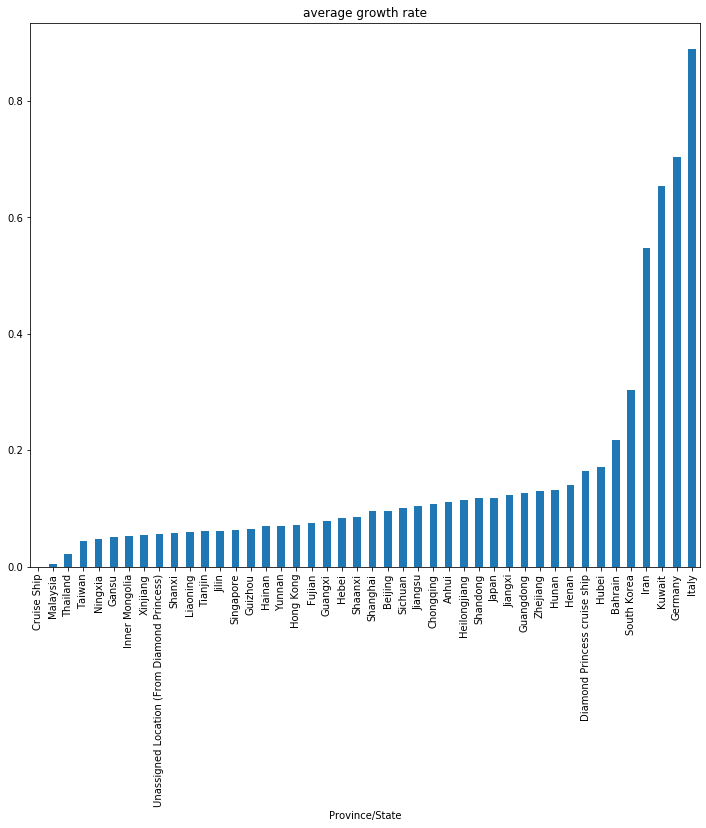

In [17]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().\
    sort_values().plot.bar(figsize=(12,10),title='average growth rate')

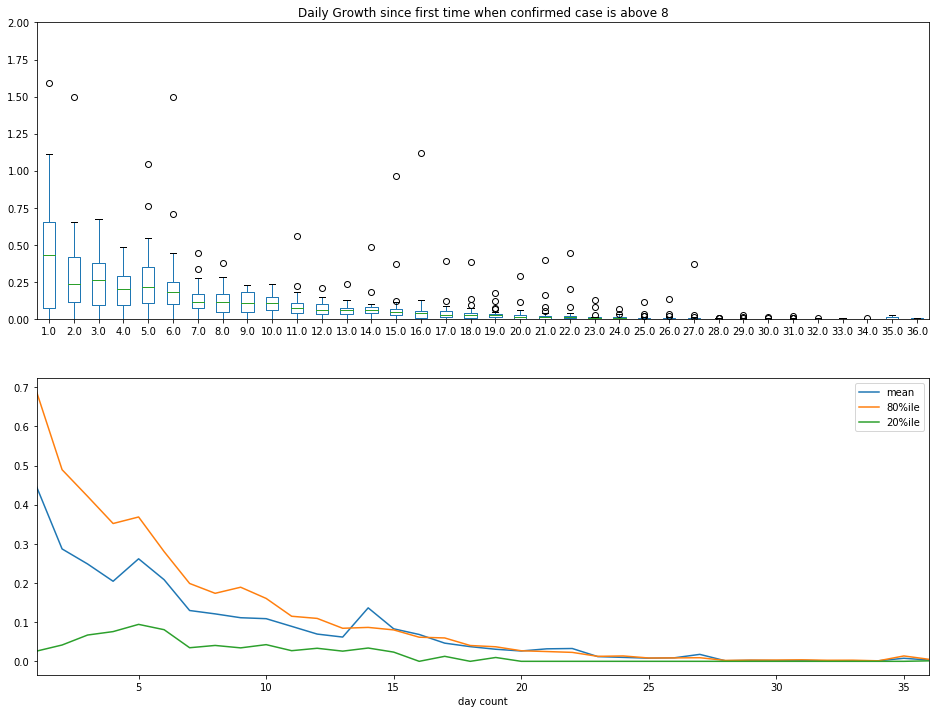

In [18]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize =(16,12))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [19]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
17,Hubei,444.0
5,Diamond Princess cruise ship,135.0
15,Henan,83.0
24,Jiangxi,72.0
21,Italy,62.0


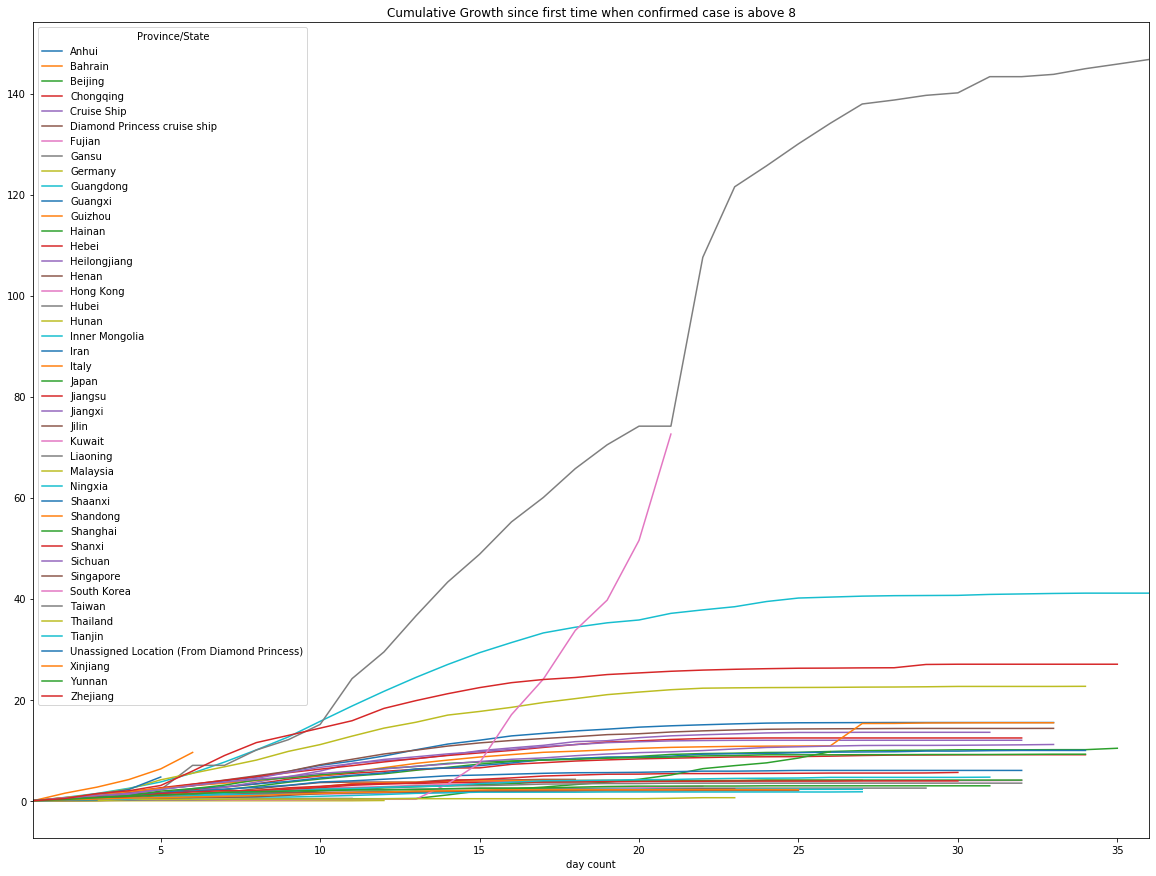

In [20]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')

cmlt_growth_df.plot.line(figsize =(20, 15), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

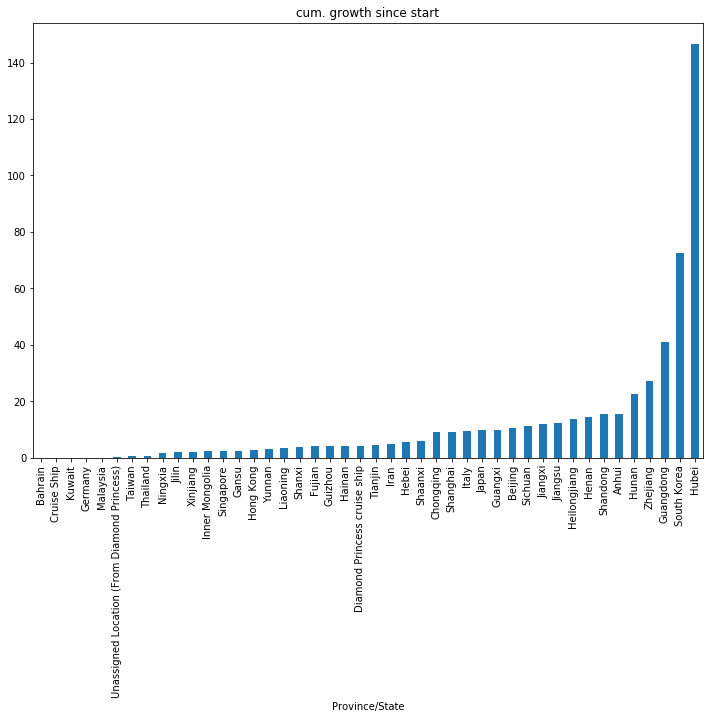

In [21]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8), title='cum. growth since start')

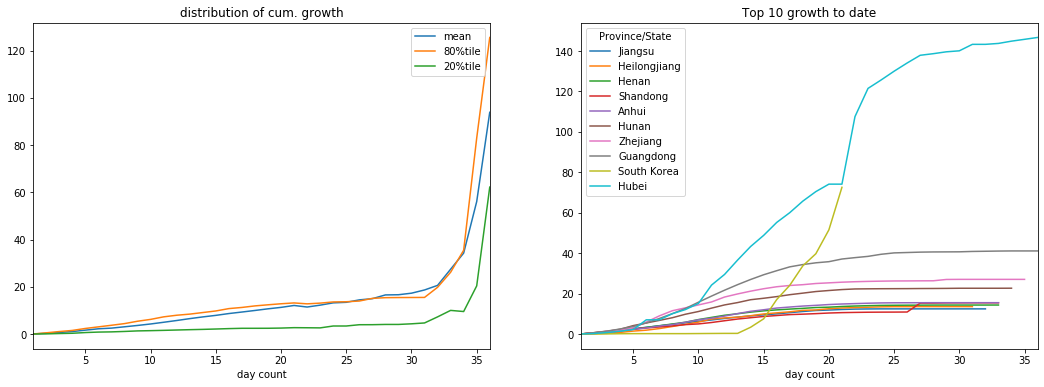

In [22]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['mean','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'Top 10 growth to date')

#### Compare China vs. Outside

In [23]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [24]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

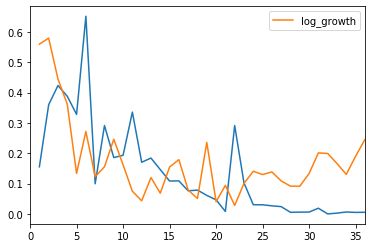

In [25]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

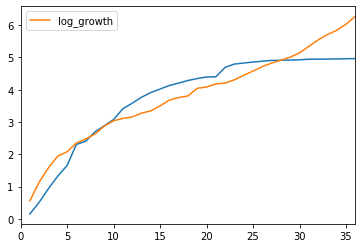

In [26]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [27]:
# The null hypothesis that the two distribution the same can't be reject by a simple T-test
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=-1.080774489486309, pvalue=0.28350696698387495)

#### Time-series Analysis on Growth Rate

In [28]:
# auto-correlation is high in China 🇨🇳  on aggregate
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.58027521  0.6181854   0.52444785  0.3992159   0.36655208
  0.27355689  0.24171921  0.20845111  0.15022112  0.06274556  0.05355989
 -0.02301315 -0.09024733 -0.08234015 -0.15121294 -0.02305515 -0.11133398
 -0.14488347 -0.14304275 -0.16736168 -0.24564433 -0.28644139 -0.29027969
 -0.29401701 -0.28645224 -0.26804583 -0.25871295 -0.24929936 -0.22724464
 -0.23613598 -0.15350017 -0.12267485 -0.08325276 -0.03796645 -0.00277194]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   36
Model:                     AutoReg(1)   Log Likelihood                  23.084
Method:               Conditional MLE   S.D. of innovations              0.125
Date:                Fri, 28 Feb 2020   AIC                             -3.986
Time:                        12:28:48   BIC                             -3.852
Sample:                             1   HQIC                            -3.939
                                   36                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0534      0.029      1.851      0.064      -0.003       0.110
log_growth.L1     0.5932      0.138      4.288      0.000       0.322       0.864
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6859           +0.0000j            1.6859            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
# auto-correlation is quite high outside of China
print(acf(outside_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is significant
model = AutoReg(outside_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.00000000e+00  6.39873085e-01  4.16017981e-01  2.37619257e-01
  1.22812882e-01  1.41050751e-01  9.68873154e-02  1.02410318e-01
  1.98452197e-02 -7.45332648e-02 -1.11439538e-01 -1.27968902e-01
 -7.98522213e-02 -6.26195784e-02 -9.62707182e-02 -6.67366904e-02
 -1.36582101e-01 -8.36379528e-02 -1.37045886e-01 -2.49134355e-01
 -2.01034184e-01 -1.82065581e-01 -1.03138271e-01 -9.36884283e-02
 -1.31647166e-01 -1.43782534e-01 -1.44829982e-01 -1.11410447e-01
 -7.18419371e-02  2.22293134e-04  2.78068337e-02 -8.96886067e-03
 -5.47019701e-03  1.45654171e-02  5.86206061e-02  4.59668377e-02]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   36
Model:                     AutoReg(1)   Log Likelihood                  40.990
Method:               Conditional MLE   S.D. of innovations              0.075
Date:                Fri, 28 Feb 2020   AIC                             -5.009
Time:                        12:28:48   BIC                             -4.875
Sample:                             1   HQIC                            -4.963
                                   36                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0523      0.021      2.482      0.013       0.011       0.094
log_growth.L1     0.6442      0.098      6.589      0.000       0.453       0.836
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5524           +0.0000j            1.5524            0.0000
-----------------------------------------------------------------------------
"""

#### Predictive Models for Singapore

In [30]:
outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index()

,Country/Region,Province/State,period,Confirmed,Recovered,Deaths
0,Afghanistan,Afghanistan,2020-02-24,1.0,0.0,0.0
1,Afghanistan,Afghanistan,2020-02-25,1.0,0.0,0.0
2,Afghanistan,Afghanistan,2020-02-26,1.0,0.0,0.0
3,Afghanistan,Afghanistan,2020-02-27,1.0,0.0,0.0
4,Algeria,Algeria,2020-02-25,1.0,0.0,0.0
...,...,...,...,...,...,...
1439,Vietnam,Vietnam,2020-02-23,16.0,14.0,0.0
1440,Vietnam,Vietnam,2020-02-24,16.0,14.0,0.0
1441,Vietnam,Vietnam,2020-02-25,16.0,16.0,0.0
1442,Vietnam,Vietnam,2020-02-26,16.0,16.0,0.0


#### Apply econometric model given 1) small dataset and 2) preference for confidence interval

In [31]:
model_df = growth_df[growth_df.index <= growth_df[growth_df['Singapore'].isna() == False].index.max()].\
    set_index('day count')
model_df = model_df.dropna(axis=1)
model_df

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shandong,Shanghai,Shanxi,Sichuan,Singapore,Thailand,Tianjin,Xinjiang,Yunnan,Zhejiang
day count,,,,,,,,,,,,,,,,,,,,,
1.0,0.538462,0.636364,1.111111,0.685714,0.083333,0.230769,0.000000,0.000000,0.500000,0.454545,...,0.703704,0.650000,0.000000,0.571429,0.166667,0.000000,0.043478,0.142857,0.692308,0.592593
2.0,0.166667,0.138889,0.315789,0.355932,0.115385,0.656250,0.565217,0.310345,0.212121,0.354167,...,0.630435,0.212121,0.296296,0.568182,0.000000,0.000000,0.125000,0.208333,0.250000,0.441860
3.0,0.514286,0.658537,0.466667,0.050000,0.379310,0.471698,0.277778,0.210526,0.075000,0.261538,...,0.266667,0.325000,0.114286,0.304348,0.071429,0.000000,0.148148,0.103448,0.272727,0.677419
4.0,0.433962,0.176471,0.200000,0.202381,0.275000,0.423077,0.108696,0.260870,0.069767,0.170732,...,0.368421,0.245283,0.205128,0.200000,0.100000,0.280000,0.032258,0.125000,0.185714,0.230769
5.0,0.315789,0.137500,0.113636,0.188119,0.078431,0.360360,0.137255,0.103448,0.130435,0.083333,...,0.215385,0.454545,0.404255,0.314815,0.212121,0.000000,0.281250,0.083333,0.120482,0.351562
6.0,0.185000,0.219780,0.238095,0.200000,0.036364,0.370861,0.344828,0.109375,0.192308,0.086538,...,0.164557,0.166667,0.121212,0.246479,0.125000,0.000000,0.170732,0.076923,0.129032,0.710983
7.0,0.253165,0.027027,0.159341,0.104167,0.087719,0.338164,0.115385,0.140845,0.032258,0.115044,...,0.119565,0.205357,0.094595,0.169492,0.044444,0.031250,0.250000,0.071429,0.114286,0.445946
8.0,0.144781,0.219298,0.170616,0.125786,0.000000,0.277978,0.149425,0.098765,0.125000,0.071429,...,0.116505,0.251852,0.000000,0.115942,0.063830,0.000000,0.116667,0.088889,0.042735,0.257009
9.0,0.200000,0.208633,0.214575,0.083799,0.080645,0.231638,0.110000,0.112360,0.111111,0.162963,...,0.126087,0.076923,0.185185,0.099567,0.160000,0.000000,0.029851,0.122449,0.049180,0.113383


In [32]:
model_df.corr()['Singapore'].sort_values(ascending=False).head(10)

Province/State
Singapore       1.000000
Heilongjiang    0.758880
Shanghai        0.669746
Shaanxi         0.653909
Anhui           0.639396
Hainan          0.606754
Jiangxi         0.589133
Hunan           0.576663
Liaoning        0.549266
Shanxi          0.544896
Name: Singapore, dtype: float64

In [33]:
var_model = VAR(model_df[['Singapore','Shanghai']])
results = var_model.fit(maxlags=1)
results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Feb, 2020
Time:                     12:28:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.3063
Nobs:                     22.0000    HQIC:                  -10.5338
Log likelihood:           60.2092    FPE:                2.49049e-05
AIC:                     -10.6039    Det(Omega_mle):     1.92864e-05
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.028600         0.017628            1.622           0.105
L1.Singapore         0.399316         0.258054            1.547           0.122
L1.Shanghai          0.020532         0.098178            0.

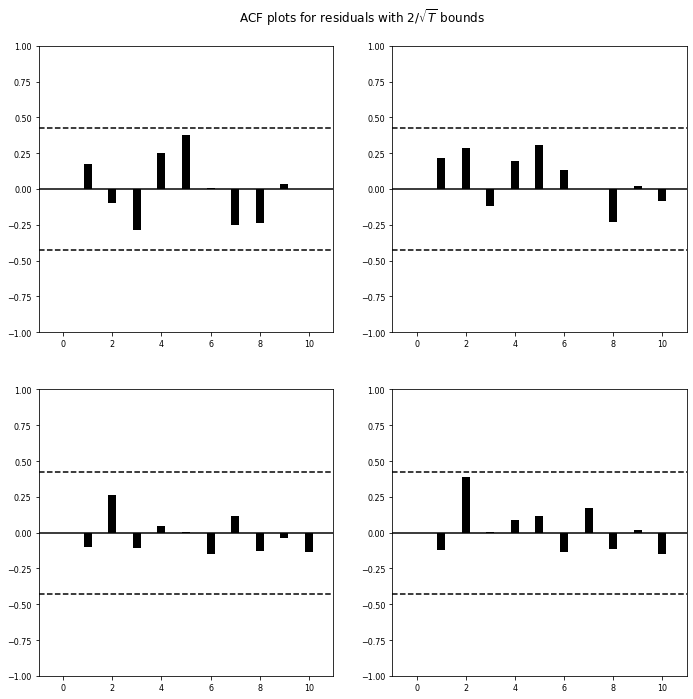

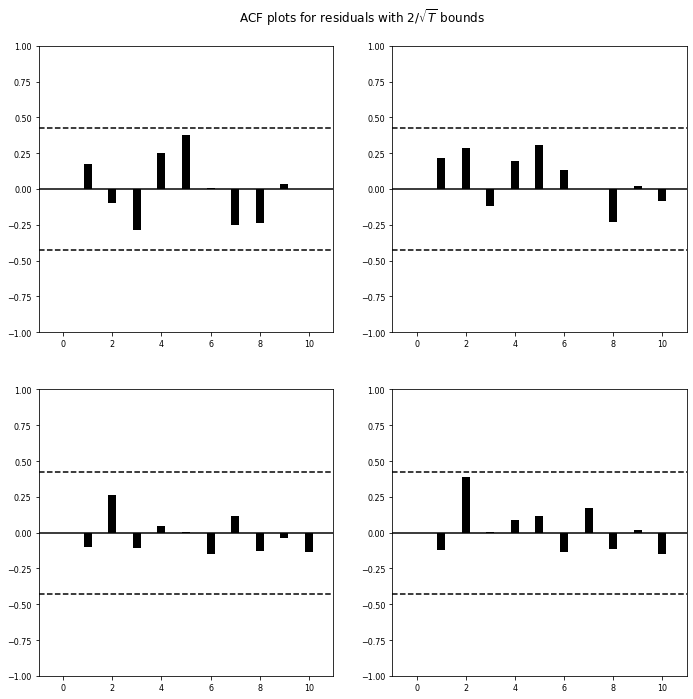

In [34]:
results.plot_acorr()

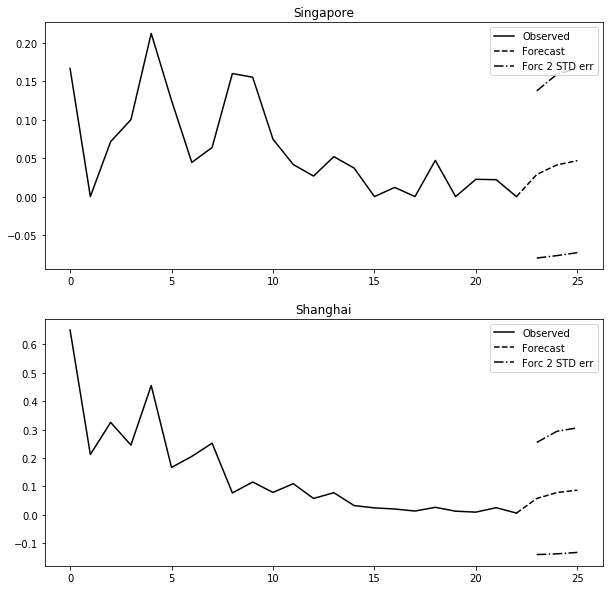

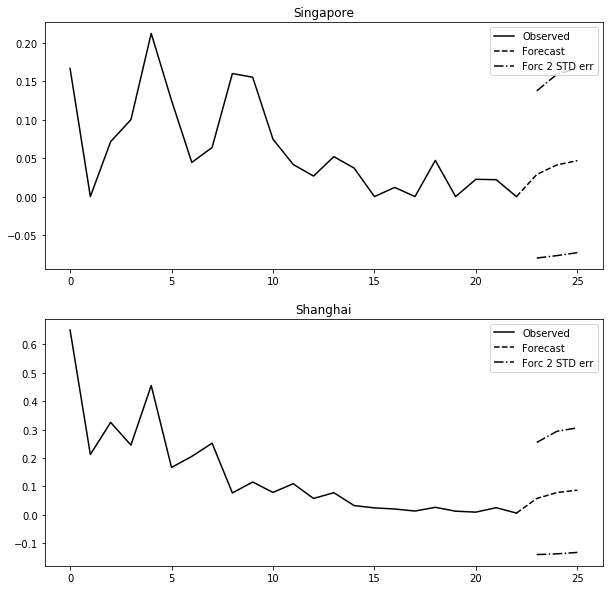

In [35]:
# Make forecast
results.plot_forecast(3)

In [36]:
# model_df[['Singapore','Hong Kong']]

# fcst_df

# fcst_df.loc[10,['Singapore','Hong Kong']].values

# np.array(fcst)

# np.array(fcst).flatten()

In [37]:
# day to be forecasted
day_forecat = model_df.index.max() + 1

In [38]:
fcst = results.forecast_interval(model_df[['Singapore','Shanghai']].values[-2:,:], 1)

In [39]:
fcst_df = heavy_affect_df[heavy_affect_df['Province/State'].isin(['Singapore','Shanghai'])].pivot(index ='day count',
                                                                                         columns = 'Province/State',
                                                                                        values = 'Confirmed')

In [40]:
fcst_num = ((np.array(fcst) + 1 ) * fcst_df.loc[day_forecat-1,['Singapore','Shanghai']].values).flatten()

In [41]:
fcst_df['Singapore_f_m'] = np.nan
fcst_df['Shanghai_f_m'] = np.nan
fcst_df['Singapore_f_lo'] = np.nan
fcst_df['Shanghai_f_lo'] = np.nan
fcst_df['Singapore_f_up'] = np.nan
fcst_df['Shanghai_f_up'] = np.nan

fcst_df.loc[day_forecat,['Singapore_f_m','Shanghai_f_m','Singapore_f_lo',
                'Shanghai_f_lo','Singapore_f_up','Shanghai_f_up']] = fcst_num

fcst_df.loc[day_forecat - 1, ['Singapore_f_m','Singapore_f_lo','Singapore_f_up']] = fcst_df.loc[day_forecat - 1,'Singapore']
fcst_df.loc[day_forecat - 1, ['Shanghai_f_m','Shanghai_f_lo','Shanghai_f_up']] = fcst_df.loc[day_forecat - 1,'Shanghai']

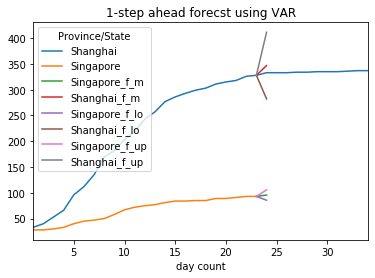

In [42]:
fcst_df.plot.line(title = '1-step ahead forecst using VAR')

### Recover rate using the latest data available

In [43]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24,NaN,NaN,NaN,0.000000
1,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25,1.0,0.0,0.0,0.000000
2,Afghanistan,Afghanistan,02,26,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-26,1.0,0.0,0.0,0.000000
3,Afghanistan,Afghanistan,02,27,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-27,1.0,0.0,0.0,0.000000
4,Algeria,Algeria,02,25,2020-02-25 21:43:03,1.0,0.0,0.0,2020-02-25,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,United Arab Emirates,United Arab Emirates,02,26,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-26,13.0,0.0,0.0,0.307692
530,United Arab Emirates,United Arab Emirates,02,27,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-27,13.0,0.0,0.0,0.307692
531,Vietnam,Vietnam,02,25,2020-02-25 06:53:02,16.0,16.0,0.0,2020-02-25,16.0,0.0,0.0,1.000000
532,Vietnam,Vietnam,02,26,2020-02-25 06:53:02,16.0,16.0,0.0,2020-02-26,16.0,0.0,0.0,1.000000


Recovery over total confirmed cases: 40.09%


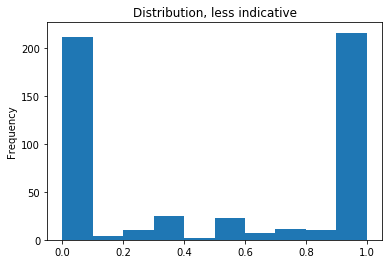

In [44]:
# Recovery rate
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Recovery over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Mortality over total confirmed cases: 3.34%


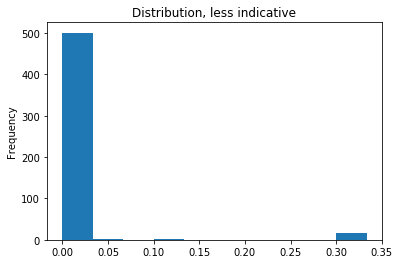

In [45]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df['mortality rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Mortality over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [46]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [47]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)